In [2]:
import torch
import re

from torchvision import models, datasets, transforms
import os
import time

In [3]:

data_dir = 'D:/NEUB/MachineLearning/ThesisProject/x-rayImages/chest_xray/chest_xray'

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomGrayscale(p=0.3),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=(-7, 7)),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.RandomCrop((180,180)),
        transforms.ToTensor(),
        transforms.Normalize([0.0020],[0.0010])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.0020],[0.0010])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.0020],[0.0010])
    ])
}

# Load the datasets and apply the transformations
img_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), transform=data_transforms[x])
    for x in ['train', 'val', 'test']
}

# Create data loaders
dataloaders = {
    x: torch.utils.data.DataLoader(img_datasets[x], batch_size=32, shuffle=True, num_workers=4)
    for x in ['train', 'val', 'test']
}

# Get dataset sizes
dataset_sizes = {x: len(img_datasets[x]) for x in ['train', 'val', 'test']}
print(dataset_sizes)

# Get class names
class_names = img_datasets['train'].classes
print(class_names)

# Get class names test
class_names_test = img_datasets['test'].classes
print(class_names_test)


{'train': 5216, 'val': 16, 'test': 624}
['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']


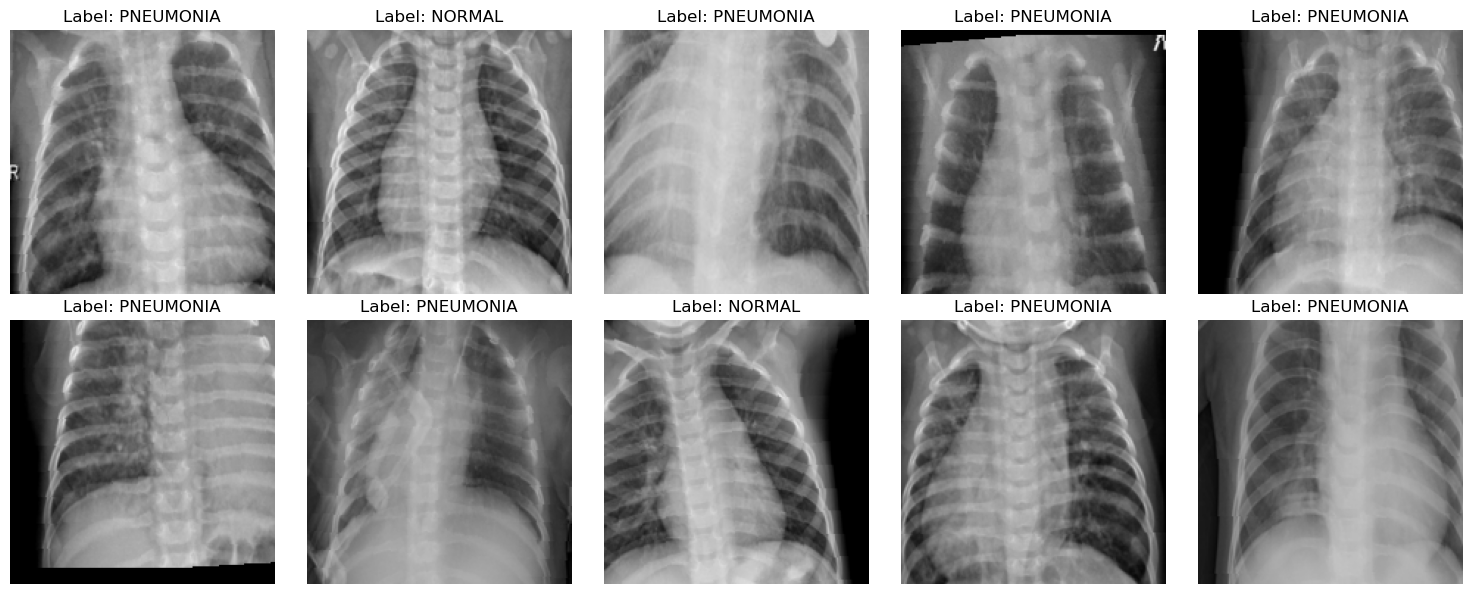

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Choose the dataset to visualize (train or val)
dataset = img_datasets['train']

# Select a few random samples from the dataset
samples = np.random.choice(len(dataset), size=10, replace=False)

# Plot the augmented images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, sample in enumerate(samples):
    row = i // 5
    col = i % 5
    
    image, label = dataset[sample]
    image = image.permute(1, 2, 0)  
    image = (image * 0.0010) + 0.0020  # Unnormalize the image
    axes[row, col].imshow(image)
    axes[row, col].set_title(f'Label: {class_names[label]}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


In [5]:
model = models.densenet161(pretrained = True)

c:\Users\HP\.conda\envs\ForML\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\.conda\envs\ForML\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# freezing the layers of the pre-trained model
i = 0
for freeze_parameters in model.parameters():
    freeze_parameters.requires_grad = False
    i+=1
print(i)
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

484
28681000


In [7]:
import torch.nn as nn

num_input_features = model.classifier.in_features
print(num_input_features)
model.classifier = nn.Linear(num_input_features, 2)

2208


In [8]:
# define the loss function
# which helps to measures the error between the predicted and true labels for multiclass classification.
criteration = nn.CrossEntropyLoss()

In [9]:
# Define the aptimization loss
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

# select the Adam optimizer to update the weights of the linear layer during training.
# The optimizer takes the parameters of the model as input.

In [10]:
# set the divice 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# move the model to the device
model = model.to(device)

num_epochs = 10

best_loss = float('inf')
best_weights = None

# ...

for epoch in range(num_epochs):
    since = time.time()
    running_loss = 0.0
    running_corrects = 0
    val_loss = 0.0
    val_corrects = 0
    
    # set the model in training mode
    model.train()

    for inputs, labels in dataloaders['train']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        features = model(inputs)
        outputs = features

        # compute the loss
        loss = criteration(outputs, labels)

        # backward pass
        loss.backward()

        # update the parameter
        optimizer.step()

        # calculate training accuracy
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    # calculate training loss and accuracy
    epoch_loss = running_loss / dataset_sizes['train']
    epoch_acc = running_corrects.double() / dataset_sizes['train']

    model.eval()

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward pass
            features = model(inputs)
            outputs = features

            # calculate the loss
            val_loss += criteration(outputs, labels).item() * inputs.size(0)

            # calculate validation accuracy
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)

    # calculate validation loss and accuracy
    val_loss = val_loss / dataset_sizes['val']
    val_acc = val_corrects.double() / dataset_sizes['val']

    # Check if current validation loss is better than the best loss
    if val_loss < best_loss:
        best_loss = val_loss
        best_weights = model.state_dict()

    # Print epoch, training loss, training accuracy, validation loss, and validation accuracy
    print(f'Epoch {epoch+1}/{num_epochs}: Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}, '
          f'Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

time_elapsed = time.time() - since
print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")

# Load the best weights
model.load_state_dict(best_weights)



Epoch 1/10: Training Loss: 0.2770 Acc: 0.8865, Validation Loss: 0.8358 Acc: 0.5625
Epoch 2/10: Training Loss: 0.1757 Acc: 0.9296, Validation Loss: 0.3562 Acc: 0.8125
Epoch 3/10: Training Loss: 0.1645 Acc: 0.9367, Validation Loss: 0.3203 Acc: 0.8125
Epoch 4/10: Training Loss: 0.1536 Acc: 0.9411, Validation Loss: 0.4026 Acc: 0.7500
Epoch 5/10: Training Loss: 0.1451 Acc: 0.9438, Validation Loss: 0.4943 Acc: 0.6875
Epoch 6/10: Training Loss: 0.1489 Acc: 0.9448, Validation Loss: 0.4105 Acc: 0.7500
Epoch 7/10: Training Loss: 0.1433 Acc: 0.9452, Validation Loss: 0.3456 Acc: 0.8125
Epoch 8/10: Training Loss: 0.1466 Acc: 0.9411, Validation Loss: 0.3052 Acc: 0.8750
Epoch 9/10: Training Loss: 0.1302 Acc: 0.9513, Validation Loss: 0.3501 Acc: 0.7500
Epoch 10/10: Training Loss: 0.1246 Acc: 0.9559, Validation Loss: 0.4496 Acc: 0.7500
Training complete in 12m 29s


<All keys matched successfully>

In [11]:
# calculate the test accuracy
test_corrects = 0

model.eval()

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        features = model(inputs)
        outputs = features

        # Calculate test accuracy
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels.data)

# Calculate test accuracy
test_acc = test_corrects.double() / dataset_sizes['test']

# Print test accuracy
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8894


In [14]:
print(time_elapsed)

749.4690022468567


### Calculating Confusion Matrix, presion and recall

In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score,precision_score,recall_score

In [17]:
# Calculate test accuracy, precision, and recall
test_corrects = 0
predicted_labels = []
true_labels = []
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [18]:
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        features = model(inputs)
        outputs = features

        # Calculate test accuracy
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels.data)

        # Store predicted and true labels for confusion matrix
        predicted_labels.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
    
# Calculate test accuracy
test_acc = test_corrects.double() / dataset_sizes['test']

# Calculate confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels)

# Calculate precision and recall
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')

In [19]:
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print('Confusion Matrix:')
print(confusion_mat)

Test Accuracy: 0.8894
Precision: 0.8973
Recall: 0.8662
Confusion Matrix:
[[181  53]
 [ 16 374]]


In [20]:
# calculating f1_score
from sklearn.metrics import f1_score

In [21]:
f1_s = f1_score(true_labels,predicted_labels,average='macro')
print(f1_s)

0.8777259341090005
